# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [5]:
!python --version

Python 3.8.13


In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

from dea_tools.plotting import rgb
from dea_tools.bandindices import calculate_indices

### Constants

In [2]:
# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/Sentinel2withIndices_"
fileextn = ".pkl"

filespecifier = "DublinSA_2020to2022_Mar"

# Survey Area origin point
survey_origin = [ 138.3014576691405, -34.45961608199659 ] # WSW of Dublin,SA
timebands = [["2020-03-01","2020-03-05"], # Mar 2020
             ["2021-03-01","2021-03-05"], # Mar 2021
             ["2022-03-01","2022-03-05"]] # Mar 2022

# Survey Area (Region of Interest)
epsg3577 = 'EPSG:3577'            # EPSG:3577: GDA94 / Australian Albers projection
pixel_resolution = (-10,10)       # Each pixel is of 10m x 10m resolution
survey_tilesize = (5120,5120)     # size of each tile in metres
survey_tiles = (5,5)              # number of horizontal and vertical tiles

# Satellite datasets
collections = ["s2a_ard_granule","s2b_ard_granule"] # Sentinel-2A and 2B MSI Definitive ARD - NBART and Pixel Quality
bands = ("nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1") # Satellite Bands

# The following band indices are added to the datasets
#        'NDVI' (Normalised Difference Vegetation Index, Rouse 1973)
#        'NDWI' (Normalised Difference Water Index, McFeeters 1996)
#        'kNDVI' (Non-linear Normalised Difference Vegetation Index, Camps-Valls et al. 2021)
#         Note: kNDVI is more resistant to saturation, bias, and complex phenological cycles
#               and shows enhanced robustness to noise and stability across spatial and temporal scales.
additional_bands = ['NDVI','kNDVI','NDWI']

### Define and Display Survey Area Grid Tiles

<AxesSubplot:>

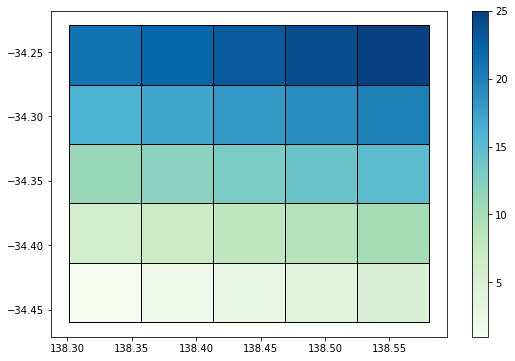

In [3]:
# Subdivide survey area into tiles
surveyarea_polygons = dea_fns.calc_surveyarea_polygons( origin=survey_origin,
                                                       tileresolution=survey_tilesize,
                                                       numtiles=survey_tiles)
# Add polygons to geodataframe
gdf_surveyarea = gpd.GeoDataFrame(columns=["tile", "geometry"])

tilenum = 0
for surveyarea_polygon in surveyarea_polygons:
    tilenum +=1
    gdf_surveyarea.loc[tilenum] = (tilenum,surveyarea_polygon)

# Save data set to pickle file
saveDataset(basepath + filespecifier + "_polygons" + fileextn, gdf_surveyarea)

# display Tile areas
gdf_surveyarea.plot(column="tile", kind='geo', figsize=(9,6), cmap='GnBu', legend=True, edgecolor="black")

### Open Catalog & Extract images from Survey area

In [4]:
catalog = pystac_client.Client.open('https://explorer.sandbox.dea.ga.gov.au/stac')

stime = begin_timer()

# Iterate through each GeoDataFrame polygon
# Extract bands for each polygon for each time period specified

surveyarea_ds = []

for t in timebands:
    i=0
    datem = datetime. datetime. strptime(t[0], "%Y-%m-%d")
    y = datem.year # year
    m = datem.month # month
    for p in surveyarea_polygons:
        i+=1
        bb = dea_fns.convert_poly2bbox(p)
        
        query = catalog.search( bbox=bb, collections=collections, datetime=f"{t[0]}/{t[1]}" )
        items = list(query.get_items()) # Search the STAC catalog
        
        print("-----------------------------------------")
        print(f"Time band: {t[0]} to {t[1]}")
        print(f"Tile #: {i}")
        print(f"BoundingBox: {bb}")
        print(f"Found: {len(items):d} datasets")
        
        if len(items) > 0:
            ds = odc.stac.load( items,
                                bands=bands,
                                crs=epsg3577,
                                resolution=pixel_resolution,
                                chunks={},
                                groupby="solar_day",
                                bbox=bb)

            calculate_indices(ds=ds, index=additional_bands, collection='ga_s2_1', inplace=True)
            surveyarea_ds.append([t, y, m, len(items), i, p, ds])
        
end_timer(stime)

# Save data set to pickle file
saveDataset(basepath + filespecifier + fileextn, surveyarea_ds)

[ Begin timer at Fri May 13 14:53:54 2022 ]
-----------------------------------------
Time band: 2020-03-01 to 2020-03-05
Tile #: 1
BoundingBox: BoundingBox(left=138.3014576691405, bottom=-34.45961608199659, right=138.35730225492216, top=-34.413570815773554)
Found: 4 datasets
-----------------------------------------
Time band: 2020-03-01 to 2020-03-05
Tile #: 2
BoundingBox: BoundingBox(left=138.35730225492216, bottom=-34.45961608199659, right=138.41314684070383, top=-34.413570815773554)
Found: 4 datasets
-----------------------------------------
Time band: 2020-03-01 to 2020-03-05
Tile #: 3
BoundingBox: BoundingBox(left=138.41314684070383, bottom=-34.45961608199659, right=138.46899142648547, top=-34.413570815773554)
Found: 2 datasets
-----------------------------------------
Time band: 2020-03-01 to 2020-03-05
Tile #: 4
BoundingBox: BoundingBox(left=138.46899142648547, bottom=-34.45961608199659, right=138.52483601226714, top=-34.413570815773554)
Found: 2 datasets
---------------------

-----------------------------------------
Time band: 2021-03-01 to 2021-03-05
Tile #: 12
BoundingBox: BoundingBox(left=138.35730225492216, bottom=-34.367525549550514, right=138.41314684070383, top=-34.321480283327475)
Found: 7 datasets
-----------------------------------------
Time band: 2021-03-01 to 2021-03-05
Tile #: 13
BoundingBox: BoundingBox(left=138.41314684070383, bottom=-34.367525549550514, right=138.46899142648547, top=-34.321480283327475)
Found: 4 datasets
-----------------------------------------
Time band: 2021-03-01 to 2021-03-05
Tile #: 14
BoundingBox: BoundingBox(left=138.46899142648547, bottom=-34.367525549550514, right=138.52483601226714, top=-34.321480283327475)
Found: 4 datasets
-----------------------------------------
Time band: 2021-03-01 to 2021-03-05
Tile #: 15
BoundingBox: BoundingBox(left=138.52483601226714, bottom=-34.367525549550514, right=138.58068059804881, top=-34.321480283327475)
Found: 4 datasets
-----------------------------------------
Time band: 202

-----------------------------------------
Time band: 2022-03-01 to 2022-03-05
Tile #: 23
BoundingBox: BoundingBox(left=138.41314684070383, bottom=-34.27543501710443, right=138.46899142648547, top=-34.22938975088139)
Found: 2 datasets
-----------------------------------------
Time band: 2022-03-01 to 2022-03-05
Tile #: 24
BoundingBox: BoundingBox(left=138.46899142648547, bottom=-34.27543501710443, right=138.52483601226714, top=-34.22938975088139)
Found: 2 datasets
-----------------------------------------
Time band: 2022-03-01 to 2022-03-05
Tile #: 25
BoundingBox: BoundingBox(left=138.52483601226714, bottom=-34.27543501710443, right=138.58068059804881, top=-34.22938975088139)
Found: 2 datasets
[ End timer at   Fri May 13 14:54:07 2022 | Duration: 12.237735 s ]
